In [10]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # Suppress some SHAP/XGBoost warnings
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None # default='warn', suppress SettingWithCopyWarning for imputation steps


In [11]:
######################################################################
# PULL BASE XGBOOST MODELS AND DATA NEEDED
######################################################################

# Call Xgboost model with wildfire features
loaded_model_ubj = XGBRegressor()
loaded_model_ubj.load_model('../20_Model/xgboost_wf_model.ubj') # or 'xgboost_base_model.ubj'

# Pull required datasets
test_data = pd.read_csv("../50_Spillover_Experiment/test_data_spillover.csv")
X_test_wf_processed = pd.read_csv("../50_Spillover_Experiment/X_test_spillover.csv")

# Define our groups and Target Variable
TARGET_VARIABLE = 'PCT_PRICE_CHANGE_DETRENDED (%)'

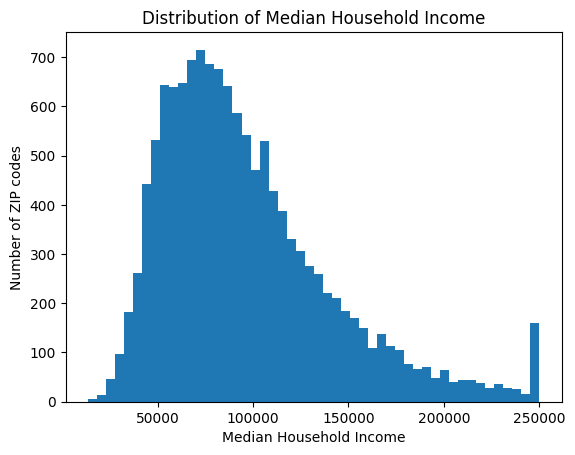

INCOMExRACE
Middle Income POC Area      5757
Middle Income White Area    3886
Low Income POC Area         2169
Low Income White Area        709
High Income White Area       428
High Income POC Area         289
Name: count, dtype: int64


In [12]:
######################################################################
# CREATE INCOMExRACE GROUPS
######################################################################

# Look at distribution of income across households
test_data["Median_Household_Income"] = test_data["Median_Household_Income"].astype(float)


# Plot histogram
plt.hist(test_data["Median_Household_Income"], bins=50)
plt.xlabel("Median Household Income")
plt.ylabel("Number of ZIP codes")
plt.title("Distribution of Median Household Income")
plt.show()

# Double check the max income
test_data["Median_Household_Income"].max() # IT'S BEEN CAPPED TO 250K (does not include the ultra wealthy)

# Define California-specific income thresholds
low_income_threshold = 61000   # Below $61k = Low Income
high_income_threshold = 184000 # Above $184k = High Income

# Function to assign demographic bucket
def assign_demographic_bucket(row):
    white_pct = row['White_Portion']
    income = row['Median_Household_Income']

    # Race dominance
    if white_pct >= 60: # Majority (%)
        race_group = 'White'
    else:
        race_group = 'POC'

    # Income level
    if income < low_income_threshold:
        income_group = 'Low Income'
    elif income <= high_income_threshold:
        income_group = 'Middle Income'
    else:
        income_group = 'High Income'

    # Combine into final bucket
    return f"{income_group} {race_group} Area"

# Apply to your dataframe
test_data['INCOMExRACE'] = test_data.apply(assign_demographic_bucket, axis=1)

# Quick check: how many areas per bucket
print(test_data['INCOMExRACE'].value_counts())

In [13]:
######################################################################
# FAIRNESS AND BIAS BY DEMOGRAPHIC 
######################################################################

# Step 1: Define demographic buckets
demographic_groups = test_data['INCOMExRACE'].unique()

# Step 2: Store results
results_by_demographic = {}

# Step 3: Loop through each demographic group
for group in demographic_groups:
    print(f"Evaluating group: {group}")

    # Subset the test data
    mask = test_data['INCOMExRACE'] == group
    X_test_subset = X_test_wf_processed.loc[mask]  # preprocessed features (without Demographic_Bucket!)
    y_test_subset = test_data.loc[mask, TARGET_VARIABLE]

    # Check if empty
    if X_test_subset.empty:
        print(f"Warning: No samples found for group '{group}'. Skipping.")
        continue

    # Predict
    y_pred_subset = loaded_model_ubj.predict(X_test_subset)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_subset, y_pred_subset))
    mae = mean_absolute_error(y_test_subset, y_pred_subset)
    r2 = r2_score(y_test_subset, y_pred_subset)

    # Save results
    results_by_demographic[group] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Step 4: Print results nicely
print("\n--- Fairness Performance by Demographic Bucket ---")
for group, metrics in results_by_demographic.items():
    print(f"\nGroup: {group}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAE : {metrics['MAE']:.4f}")
    print(f"  R²  : {metrics['R2']:.4f}")



Evaluating group: High Income White Area
Evaluating group: Middle Income White Area
Evaluating group: Middle Income POC Area
Evaluating group: Low Income POC Area
Evaluating group: High Income POC Area
Evaluating group: Low Income White Area

--- Fairness Performance by Demographic Bucket ---

Group: High Income White Area
  RMSE: 3.2244
  MAE : 2.6133
  R²  : 0.8089

Group: Middle Income White Area
  RMSE: 4.1877
  MAE : 3.2621
  R²  : 0.7712

Group: Middle Income POC Area
  RMSE: 4.4032
  MAE : 3.2426
  R²  : 0.7567

Group: Low Income POC Area
  RMSE: 5.5123
  MAE : 4.1761
  R²  : 0.8428

Group: High Income POC Area
  RMSE: 2.7474
  MAE : 2.3142
  R²  : 0.8628

Group: Low Income White Area
  RMSE: 4.4066
  MAE : 3.4680
  R²  : 0.8926
